<a href="https://colab.research.google.com/github/starlingomez/preworkmac/blob/master/nba_rep_xgboost_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data loaded successfully. Shape: (56, 21)

Missing values per column:
PTS           0
AST           0
STL           0
TOV           0
FGA           0
FGM           0
FG3M          0
FG3A          0
BLK           0
FTA           0
FTM           0
PLUS_MINUS    0
REB           0
dtype: int64

Preprocessed data shape: (56, 13)

Feature correlations with REB:
REB             1.000000
USG             0.480679
FGA             0.419918
PTS             0.334835
FG3A            0.318081
FGM             0.307523
DEF_ACTIVITY    0.296663
FTM             0.243745
FTA             0.243363
FG3M            0.239937
TOV             0.238614
STL             0.192081
BLK             0.179703
FT_PCT          0.144752
PLUS_MINUS      0.137132
FG3_PCT         0.129788
AST             0.121051
FG_PCT          0.033351
Name: REB, dtype: float64


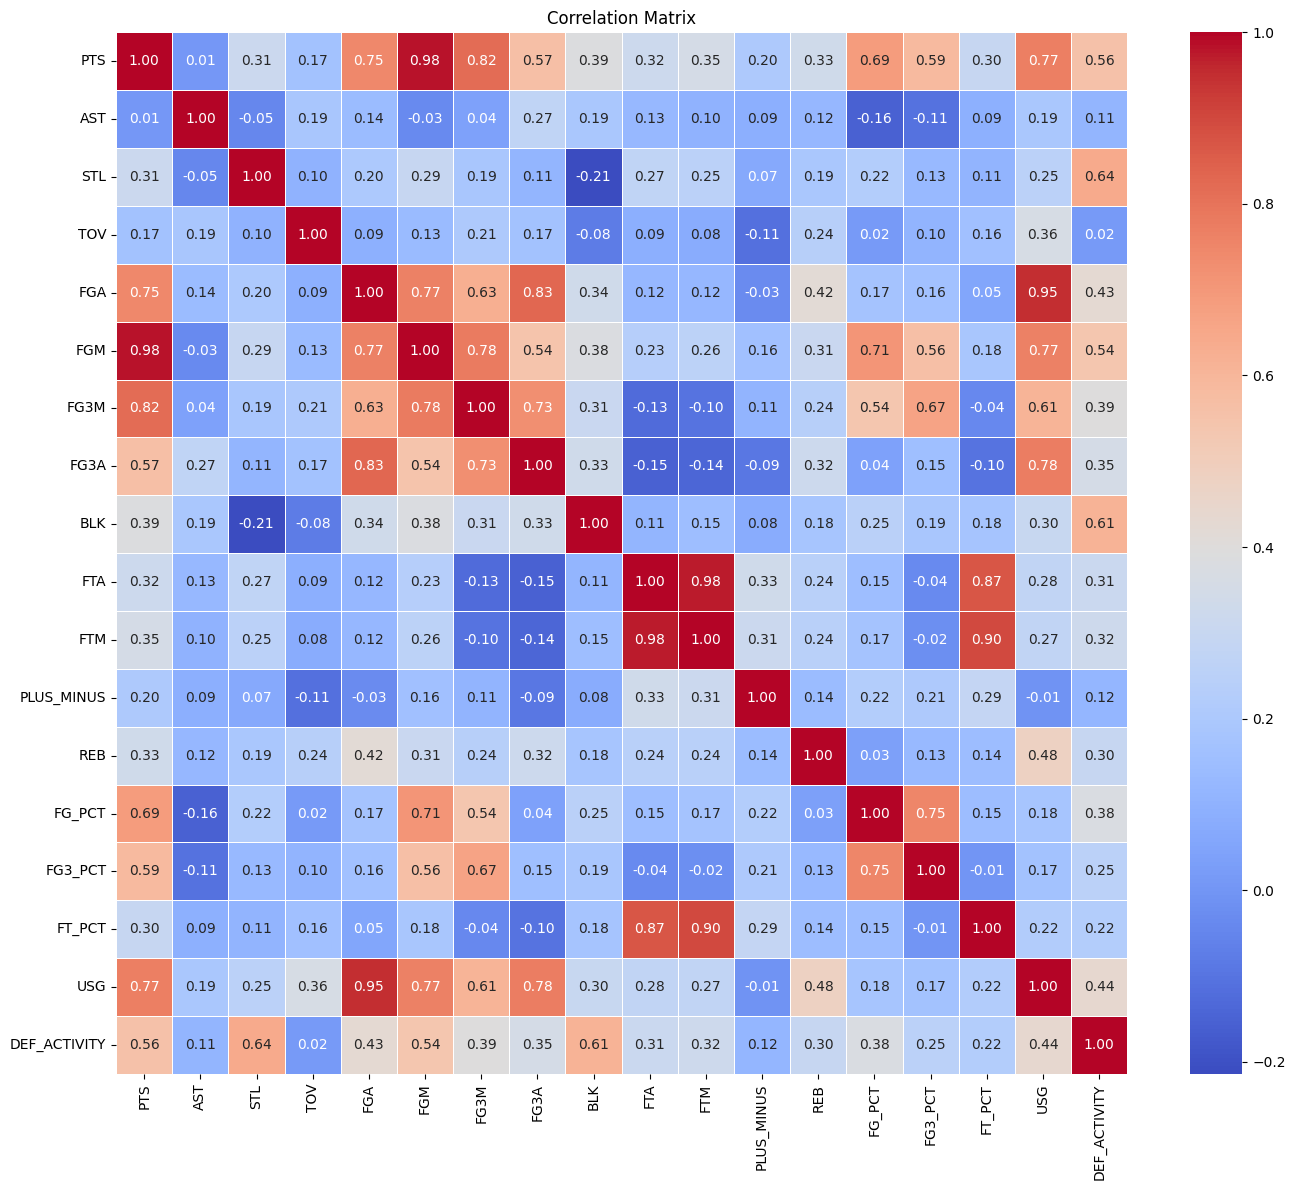


Training set: (44, 17), Test set: (12, 17)

Model Performance:
Training RMSE: 0.0675
Test RMSE: 2.1964
Training R²: 0.9992
Test R²: 0.1837
Test MAE: 1.9159


<Figure size 1200x600 with 0 Axes>

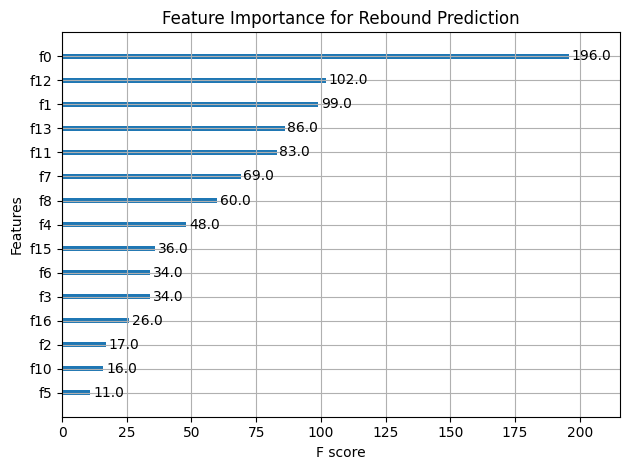


Sample Prediction for Next Game:
Predicted REB: 8.600000381469727
Actual REB: 10
Difference: 1.4

Model and scaler saved successfully.

Predictions for Upcoming Games:
   Actual_REB  Predicted_REB
0          10            8.6
1          10            8.2
2           4            7.8
3          10            8.5
4           4            2.1


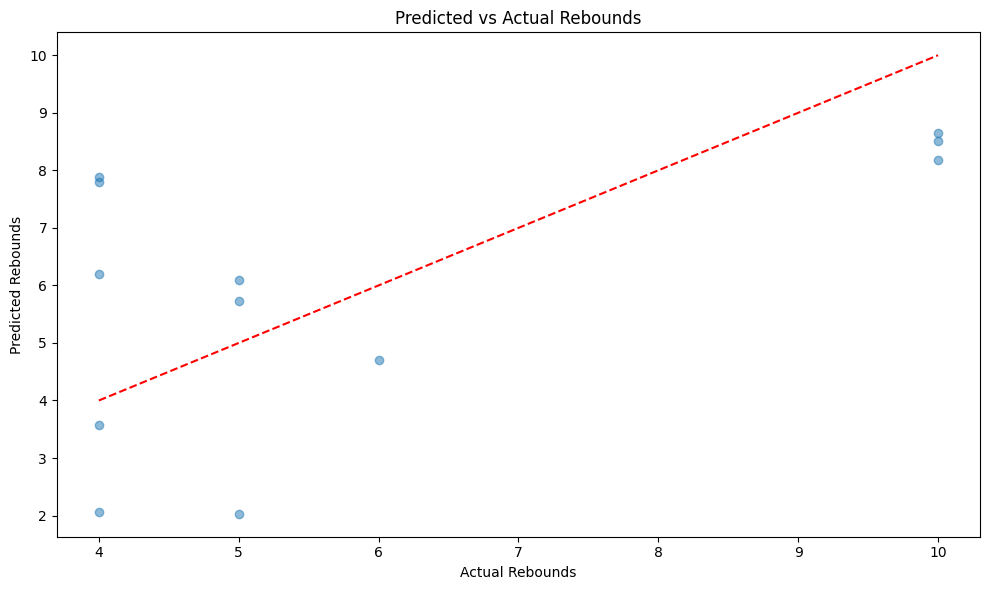


Model ready for deployment!


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# ========== Step 1: Load Data ==========
csv_path = '/content/Al Horford.csv'  # Replace with your actual file path
if not os.path.isfile(csv_path):
    raise FileNotFoundError(f"The file does not exist at the provided path: {csv_path}")

try:
    df = pd.read_csv(csv_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
except Exception as e:
    raise Exception(f"Error reading CSV file: {e}")

# ========== Step 2: Verify Required Columns ==========
features = [ 'PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']
target = 'REB'

# Check if all required columns are present
required_columns = features + [target]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the data: {missing_columns}")

# ========== Step 3: Data Preprocessing ==========
# Handle missing values
print("\nMissing values per column:")
print(df[required_columns].isnull().sum())

# Fill missing values using appropriate strategy
for col in required_columns:
    if df[col].isnull().sum() > 0:
        # For this example, filling with median but could be customized
        df[col] = df[col].fillna(df[col].median())

# Clean the data: remove rows with extreme or invalid values
# For example, remove games where a player didn't play (minutes = 0)
if 'MIN' in df.columns:
    df = df[df['MIN'] > 0]

# Create a copy of the dataframe with only the features we need
model_df = df[required_columns].copy()
print(f"\nPreprocessed data shape: {model_df.shape}")

# ========== Step 4: Feature Engineering ==========
# Create any additional features that might help prediction
# Shooting efficiency
model_df['FG_PCT'] = model_df['FGM'] / model_df['FGA'].replace(0, 1)  # Avoid division by zero
model_df['FG3_PCT'] = model_df['FG3M'] / model_df['FG3A'].replace(0, 1)
model_df['FT_PCT'] = model_df['FTM'] / model_df['FTA'].replace(0, 1)

# Usage metrics
model_df['USG'] = model_df['FGA'] + 0.44 * model_df['FTA'] + model_df['TOV']

# Defensive activity
model_df['DEF_ACTIVITY'] = model_df['STL'] + model_df['BLK']

# ========== Step 5: Exploratory Data Analysis ==========
# Check correlation with target
corr = model_df.corr()[target].sort_values(ascending=False)
print("\nFeature correlations with REB:")
print(corr)

# Plot correlation matrix
plt.figure(figsize=(14, 12))
correlation_matrix = model_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# ========== Step 6: Split Data ==========
# Split into features and target
X = model_df.drop(target, axis=1)
y = model_df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set: {X_train.shape}, Test set: {X_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== Step 7: Train XGBoost Model ==========
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Train the model
xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

# ========== Step 8: Hyperparameter Tuning ==========
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use smaller grid for demonstration purposes
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Run grid search (uncomment to use - can be time-consuming)
'''
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=small_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("\nBest parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
'''

# ========== Step 9: Model Evaluation ==========
# Make predictions
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# ========== Step 10: Feature Importance ==========
# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('Feature Importance for Rebound Prediction')
plt.tight_layout()
plt.show()

# ========== Step 11: Predictions for Next Game ==========
# Function to predict REB for a specific player
def predict_next_game_rebounds(player_data, model, scaler):
    """
    Predict next game rebounds for a player based on their stats

    Args:
        player_data: DataFrame row or dict containing player's stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        Predicted rebounds for the next game
    """
    # Convert input to DataFrame if it's a dict
    if isinstance(player_data, dict):
        player_df = pd.DataFrame([player_data])
    else:
        player_df = pd.DataFrame([player_data])

    # Apply same feature engineering as training data
    player_df['FG_PCT'] = player_df['FGM'] / player_df['FGA'].replace(0, 1)
    player_df['FG3_PCT'] = player_df['FG3M'] / player_df['FG3A'].replace(0, 1)
    player_df['FT_PCT'] = player_df['FTM'] / player_df['FTA'].replace(0, 1)
    player_df['USG'] = player_df['FGA'] + 0.44 * player_df['FTA'] + player_df['TOV']
    player_df['DEF_ACTIVITY'] = player_df['STL'] + player_df['BLK']

    # Ensure all features are present in the correct order
    feature_df = player_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(feature_df)

    # Make prediction
    prediction = model.predict(scaled_features)[0]

    # Round to 1 decimal place (reasonable for rebounds)
    return round(prediction, 1)

# Example: Predicting for a sample player
# (This would be replaced with actual player data)
sample_player = X_test.iloc[0].to_dict()  # Using first test set example
predicted_rebounds = predict_next_game_rebounds(sample_player, xgb_model, scaler)
actual_rebounds = y_test.iloc[0]

print("\nSample Prediction for Next Game:")
print(f"Predicted REB: {predicted_rebounds}")
print(f"Actual REB: {actual_rebounds}")
print(f"Difference: {abs(predicted_rebounds - actual_rebounds):.1f}")

# ========== Step 12: Save Model ==========
# Save model and scaler for future use
xgb_model.save_model('nba_player_rebounds_model.json')
import joblib
joblib.dump(scaler, 'rebounds_scaler.pkl')

print("\nModel and scaler saved successfully.")

# ========== Step 13: Batch Predictions for Upcoming Games ==========
# Function to make predictions for multiple players
def predict_upcoming_games(players_df, model, scaler):
    """
    Make rebound predictions for multiple upcoming players/games

    Args:
        players_df: DataFrame with upcoming player stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        DataFrame with original stats and predictions
    """
    # Create a copy to avoid modifying original
    result_df = players_df.copy()

    # Apply same feature engineering
    result_df['FG_PCT'] = result_df['FGM'] / result_df['FGA'].replace(0, 1)
    result_df['FG3_PCT'] = result_df['FG3M'] / result_df['FG3A'].replace(0, 1)
    result_df['FT_PCT'] = result_df['FTM'] / result_df['FTA'].replace(0, 1)
    result_df['USG'] = result_df['FGA'] + 0.44 * result_df['FTA'] + result_df['TOV']
    result_df['DEF_ACTIVITY'] = result_df['STL'] + result_df['BLK']

    # Extract features in the same order as training
    features_df = result_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(features_df)

    # Make predictions
    predictions = model.predict(scaled_features)

    # Add predictions to result (rounded to 1 decimal place)
    result_df['Predicted_REB'] = np.round(predictions, 1)

    return result_df

# Example: Predict for a sample of upcoming players/games
# (This would be replaced with actual upcoming player data)
sample_upcoming_players = X_test.head(5).copy()  # Using first 5 test examples

# Add player names if available
if 'PLAYER_NAME' in df.columns:
    sample_upcoming_players['PLAYER_NAME'] = df.loc[X_test.head(5).index, 'PLAYER_NAME'].values

predictions_df = predict_upcoming_games(sample_upcoming_players, xgb_model, scaler)

print("\nPredictions for Upcoming Games:")
if 'PLAYER_NAME' in predictions_df.columns:
    comparison_df = pd.DataFrame({
        'Player': predictions_df['PLAYER_NAME'],
        'Actual_REB': y_test.head(5).values,
        'Predicted_REB': predictions_df['Predicted_REB'].values
    })
else:
    comparison_df = pd.DataFrame({
        'Actual_REB': y_test.head(5).values,
        'Predicted_REB': predictions_df['Predicted_REB'].values
    })
print(comparison_df)

# ========== Step 14: Visualization of Predictions vs Actuals ==========
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Rebounds')
plt.ylabel('Predicted Rebounds')
plt.title('Predicted vs Actual Rebounds')
plt.tight_layout()
plt.show()

print("\nModel ready for deployment!")